In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from abtem import *

In [3]:
atoms = read('graphene.cif')

probe = Probe(energy=80e3, semiangle_cutoff=.03, focal_spread=60, defocus=50)

potential = Potential(atoms, sampling=.05)

gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=.1)

## Segmented detector

The `SegmentedDetector` is partitioned into several integration regions divided at radials and angles. This can be used for simulating differential phase contrast (DPC) imaging. 

In [86]:
from abtem.detect import SegmentedDetector

dpc_detector = SegmentedDetector(inner=90, outer=200, nbins_radial=2, nbins_angular=4)

This detector is divided into eight different integration regions, which we illustrate below.

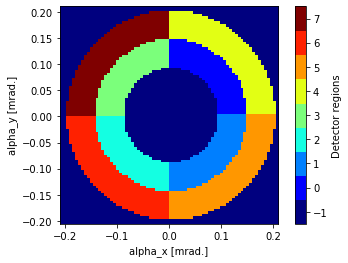

In [87]:
dpc_detector.show(potential.grid, probe.wavelength, cmap='jet', colorbar=True);

In [88]:
measurements = probe.scan(gridscan, [dpc_detector], potential, max_batch=100)

The resulting measurement is 4d. The first two dimensions represent the scan dimensions, the last two represent the radial and angular bins, respectively.

In [89]:
measurements[dpc_detector].array.shape

(25, 43, 2, 4)

abTEM does not implement plotting for 4d measurements, hence to show the results, we need to perform a reduction. The simplest reduction is just indexing, below we show the signal from the first scan position.

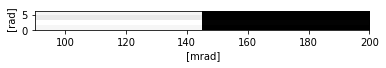

In [90]:
measurements[dpc_detector][0, 0].show();

We may also reduce the dimension by taking the mean. Below we calculate the mean detector signal, which is just a STEM image.

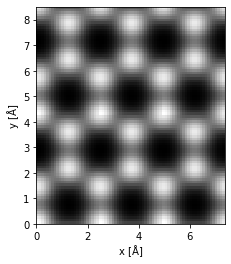

In [91]:
measurements[dpc_detector].mean((-2, -1)).tile((3, 2)).show();

To obtain a differential signal we subtract the mean of detector regions 2 and 3 from the regions 0 and 1.

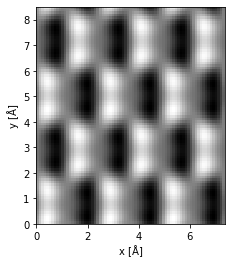

In [92]:
signal_01 = measurements[dpc_detector][:, :, 0, [0, 1]].mean(-1)
signal_23 = measurements[dpc_detector][:, :, 0, [2, 3]].mean(-1)

differential_signal = signal_01 - signal_23

differential_signal.tile((3, 2)).show();

## Flexible annular detector

The flexible annular detector allows us to choose the integration limits after running the simulation. Here, we a detector with a spacing between detector regions of 10 mrad.

In [93]:
from abtem.detect import FlexibleAnnularDetector

detector = FlexibleAnnularDetector(step_size=10)

(<matplotlib.axes._subplots.AxesSubplot at 0x1329fb52b0>,
 <matplotlib.image.AxesImage at 0x1324d45f60>)

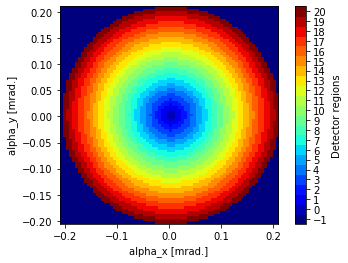

In [102]:
detector.show(potential.grid, probe.wavelength, cmap='jet', colorbar=True)

In [82]:
measurements = probe.scan(gridscan, [detector], potential, max_batch=100, pbar=True)

The resulting measurement is 3d. The first two dimensions represent the scan dimensions, the last dimension is represent the detector bins.

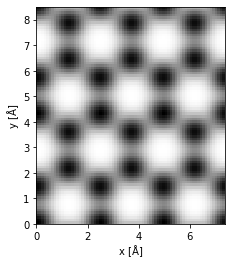

In [84]:
measurements[detector][:, :, :5].mean(-1).tile((3, 2)).show();

(<matplotlib.axes._subplots.AxesSubplot at 0x1323ca1b38>,
 <matplotlib.image.AxesImage at 0x1323d36390>)

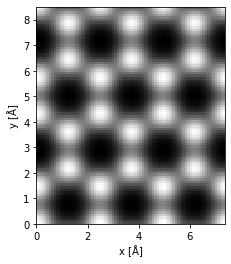

In [39]:
offset = measurements[detector].calibrations[-1].offset
sampling = measurements[detector].calibrations[-1].sampling

start = int((90 - offset) / sampling)
stop = int((200 - offset) / sampling)

measurements[detector][:, :, start:stop].mean(-1).tile((3,2)).show()

## Pixelated detector

The `PixelatedDetector` records the intensity of the fourier transformed exit wave function, i.e. a complete convergent beam electron diffraction pattern. Hence a 2D scan with this detector results in a large four-dimensional dataset (a 2D diffraction pattern recorded at every 2D probe position). The 4D datasets generated can reconstruct the results of any of the other detector geometries, hence the only downside of using this is the high memory or disk space requirement of storing the data.

In [4]:
from abtem.detect import PixelatedDetector

pixelated_detector = PixelatedDetector()

In [5]:
measurements = probe.scan(gridscan, [pixelated_detector], potential, max_batch=200)

Indexing the scan dimensions returns a single diffraction pattern.

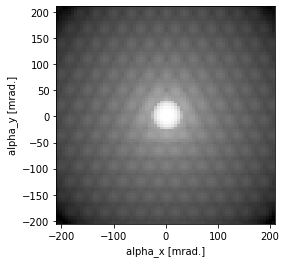

In [9]:
measurements[pixelated_detector][0,0].show(log_scale=True);

(<matplotlib.axes._subplots.AxesSubplot at 0x13200089e8>,
 <matplotlib.image.AxesImage at 0x131fbe1710>)

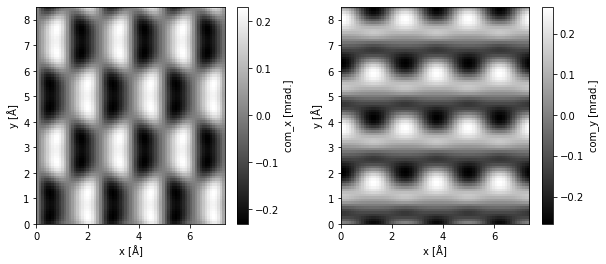

In [8]:
from abtem.measure import center_of_mass

com_x, com_y = center_of_mass(measurements[pixelated_detector])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
com_x.tile((3, 2)).show(colorbar=True, ax=ax1)
com_y.tile((3, 2)).show(colorbar=True, ax=ax2)